# Detecting arrythmia using Deep Leaning

## Loading modules

In [1]:
import pandas as pd
import numpy as np
import wfdb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Conv1D, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\mrall\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Download Dataset

In [4]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

## Loading data

Loading list of records available, from dataset available [here](https://physionet.org/content/mitdb/1.0.0/)

In [5]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

Defining invalid beats as well as abnormal beats, according to [Physiobank](https://archive.physionet.org/physiobank/annotations.shtml)

In [6]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

## Processing dataset

This function classify a beat according to its symbol and the list provided above.

In [7]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

Given a signal, the beat location, and the window to be used as a sequence, this function gets the sequence. It will return an empty array in case of an invalid beat or empty sequence.

In [8]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

The code below will build a list of labels and sequences as well as map the sequences for each patient. The percentage calculated represents the ratio of abnormal beats in each patient data.

In [9]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

Creating bins to be used to stratify the train and validation split. 

In [10]:
subject_map = pd.DataFrame(subject_map)
print(subject_map)

    subject  percentage  num_seq   start     end
0       100    0.015018     2264       0    2264
1       101    0.002691     1858    2264    4122
2       102    0.954566     2179    4122    6301
3       103    0.000962     2078    6301    8379
4       104    0.926610     2221    8379   10600
5       105    0.017941     2564   10600   13164
6       106    0.256309     2021   13164   15185
7       107    1.000000     2130   15185   17315
8       108    0.013660     1757   17315   19072
9       109    1.000000     2523   19072   21595
10      111    1.000000     2118   21595   23713
11      112    0.000790     2531   23713   26244
12      113    0.003356     1788   26244   28032
13      114    0.031500     1873   28032   29905
14      115    0.000000     1946   29905   31851
15      116    0.045757     2404   31851   34255
16      117    0.000654     1529   34255   35784
17      118    1.000000     2271   35784   38055
18      119    0.223624     1981   38055   40036
19      121    0.001

The code presented will create class in each patient is segmented.

In [11]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

Now, the dataset is split into train and validation, stratifying by the bin defined above.

In [12]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)
print(train)
print(validation)

    subject  percentage  num_seq   start     end  bin
43      230    0.000445     2248   97730   99978    0
42      228    0.177908     2046   95684   97730    0
17      118    1.000000     2271   35784   38055    2
8       108    0.013660     1757   17315   19072    0
10      111    1.000000     2118   21595   23713    2
6       106    0.256309     2021   13164   15185    1
28      207    1.000000     1851   59784   61635    2
14      115    0.000000     1946   29905   31851    0
32      212    0.664599     2740   70218   72958    2
37      219    0.033520     2148   84006   86154    0
0       100    0.015018     2264       0    2264    0
11      112    0.000790     2531   23713   26244    0
15      116    0.045757     2404   31851   34255    0
36      217    0.889192     2202   81804   84006    2
2       102    0.954566     2179    4122    6301    2
40      222    0.170170     2474   90613   93087    0
46      233    0.275660     3069  103318  106387    1
3       103    0.000962     

This function build a dataset based on the map for each split.

In [13]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [14]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [15]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

In [16]:
print(X_train)

[[[-0.60642197]
  [-0.63462348]
  [-0.64872424]
  ...
  [-0.47951519]
  [-0.3244069 ]
  [-0.31030615]]

 [[-0.95894081]
  [-0.98714232]
  [-1.01534383]
  ...
  [-2.83434104]
  [-2.6933335 ]
  [-2.2985124 ]]

 [[-0.98714232]
  [-1.01534383]
  [-1.07174684]
  ...
  [-0.6910265 ]
  [-0.67692574]
  [-0.78973177]]

 ...

 [[-0.45371176]
  [-0.52993925]
  [-0.50453009]
  ...
  [-0.47912092]
  [-0.47912092]
  [-0.52993925]]

 [[-0.32666593]
  [-0.2758476 ]
  [-0.32666593]
  ...
  [-0.37748426]
  [-0.45371176]
  [-0.45371176]]

 [[-0.47912092]
  [-0.45371176]
  [-0.42830259]
  ...
  [-0.14880178]
  [-0.19962011]
  [-0.25043844]]]


## Training the model

### CNN model

In [32]:
sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=8,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu", 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="relu",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2160, 8)           40        
_________________________________________________________________
flatten_2 (Flatten)          (None, 17280)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17280)             0         
_________________________________________________________________
output (Dense)               (None, 1)                 17281     
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val), 
    verbose = 2
)

Epoch 1/10
648/648 - 4s - loss: 1.0686 - accuracy: 0.8282 - val_loss: 1.4119 - val_accuracy: 0.7000
Epoch 2/10
648/648 - 3s - loss: 0.5293 - accuracy: 0.8807 - val_loss: 1.2489 - val_accuracy: 0.7887
Epoch 3/10
648/648 - 3s - loss: 0.9277 - accuracy: 0.8649 - val_loss: 1.4390 - val_accuracy: 0.8059
Epoch 4/10
648/648 - 3s - loss: 1.1349 - accuracy: 0.8497 - val_loss: 2.7348 - val_accuracy: 0.7047
Epoch 5/10
648/648 - 3s - loss: 0.7629 - accuracy: 0.8843 - val_loss: 2.3869 - val_accuracy: 0.7335
Epoch 6/10
648/648 - 3s - loss: 0.6684 - accuracy: 0.8893 - val_loss: 2.0067 - val_accuracy: 0.7679
Epoch 7/10
648/648 - 3s - loss: 0.4774 - accuracy: 0.8984 - val_loss: 1.8866 - val_accuracy: 0.7804
Epoch 8/10
648/648 - 3s - loss: 0.4113 - accuracy: 0.9113 - val_loss: 1.9430 - val_accuracy: 0.7781
Epoch 9/10
648/648 - 3s - loss: 0.4330 - accuracy: 0.9060 - val_loss: 1.6749 - val_accuracy: 0.7869
Epoch 10/10
648/648 - 3s - loss: 0.4215 - accuracy: 0.9172 - val_loss: 1.5731 - val_accuracy: 0.7961

In [34]:
predictions = cnn_model.predict(x=X_val, verbose=0)

In [35]:
predictions.tolist()

[[1.5345054864883423],
 [1.7732653617858887],
 [1.9537913799285889],
 [1.7889524698257446],
 [1.4445922374725342],
 [1.40602445602417],
 [1.7119617462158203],
 [1.1959863901138306],
 [1.493605613708496],
 [1.350930094718933],
 [1.999361515045166],
 [2.323838710784912],
 [2.0049078464508057],
 [1.2116061449050903],
 [0.5118604302406311],
 [0.7676708102226257],
 [1.4921410083770752],
 [1.5719252824783325],
 [1.4836668968200684],
 [1.2255247831344604],
 [0.7166026830673218],
 [0.8284820914268494],
 [1.2414429187774658],
 [1.545685887336731],
 [1.6923271417617798],
 [1.8678427934646606],
 [1.0459281206130981],
 [0.6398994326591492],
 [1.304871916770935],
 [0.7895245552062988],
 [1.0683720111846924],
 [1.2206776142120361],
 [1.3069802522659302],
 [1.217286229133606],
 [1.4577481746673584],
 [0.2683545649051666],
 [0.6128646731376648],
 [0.3515309989452362],
 [0.8773642778396606],
 [1.010952353477478],
 [0.6606197357177734],
 [0.5447777509689331],
 [0.834425687789917],
 [0.8168272376060486],

In [27]:
y_val.tolist()

[[1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1]

In [31]:
sum(abs(predictions - y_val)) / len(predictions)

array([0.18964097])

In [25]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 2s 2ms/step - loss: 0.5151 - accuracy: 0.8262


[0.5151051878929138, 0.8261929154396057]

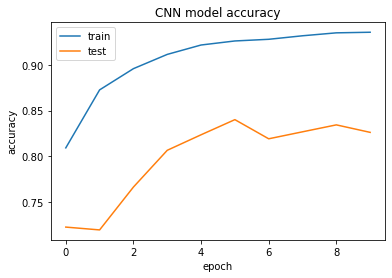

In [26]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

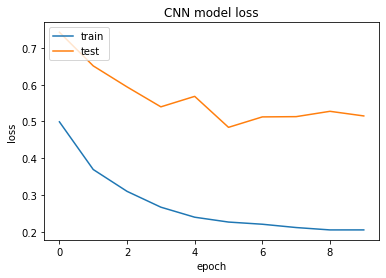

In [27]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()